In [1]:
base_path = "/content/drive/My Drive/Github/mtc-device-activation"

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')# Load saved data

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [4]:
!apt-get update
!apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,270 kB]
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,853 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [5,103 kB]
Hit:13 https://ppa.lau

In [7]:
data = np.load(f'{base_path}/communication_model/data/communication_simulation_general.npz', allow_pickle=True)
snr_db_array = data["snr_db_array"]
pilot_length_array = data["pilot_length_array"]
M = data["M"]

data = np.load(f'{base_path}/communication_model/data/communication_simulation_gamma.npz', allow_pickle=True)
all_gamma = data["all_gamma"]

data = np.load(f'{base_path}/communication_model/data/communication_simulation_z.npz', allow_pickle=True)
all_z = data["all_z"]

# === Estimation Files ===
folder_name = "snr_db_12_pilot_length_all"
file_prefix = "casbl_snr_db_12_pilot_length_all"
file_paths = [f"{base_path}/estimation/{folder_name}/data/{file_prefix}_set_{i}.npz" for i in range(1, 6)]

# === Combine Estimates ===
all_z_est = []
all_gamma_est = []

for path in file_paths:
    est = np.load(path, allow_pickle=True)
    all_z_est.append(est["z_result_all"])
    all_gamma_est.append(est["gamma_result_all"])

# Concatenate over samples
all_z_est = np.concatenate(all_z_est, axis=0)         # Shape: (num_samples, num_devices, num_antennas)
all_gamma_est = np.concatenate(all_gamma_est, axis=0) # Shape: (num_samples, num_devices)

# Confirm shapes
print("all_z shape (ground truth):", all_z.shape)
print("all_z_est shape (estimate):", all_z_est.shape)
print("all_gamma shape (ground truth):", all_gamma.shape)
print("all_gamma_est shape (estimate):", all_gamma_est.shape)

all_z shape (ground truth): (1000, 400, 4)
all_z_est shape (estimate): (1000, 6)
all_gamma shape (ground truth): (1000, 400)
all_gamma_est shape (estimate): (1000, 6)


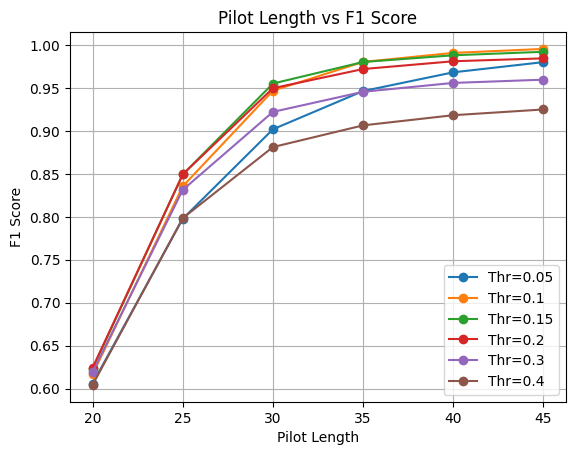

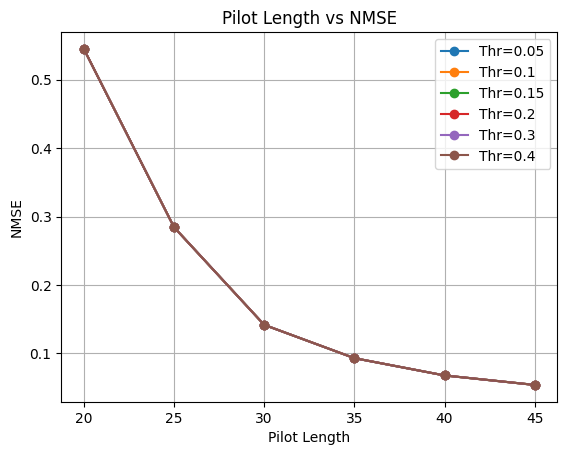

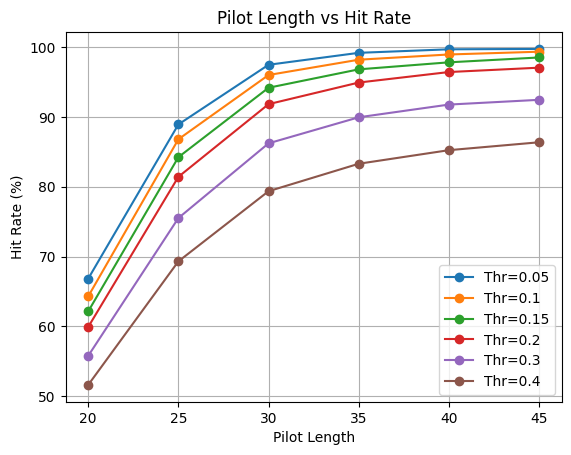

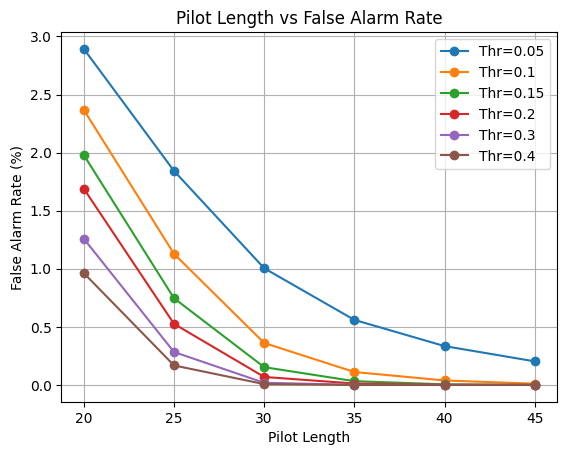

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Example threshold and pilot length arrays
threshold_array = [0.05, 0.1, 0.15, 0.2, 0.3, 0.4]  # You can adjust
num_samples = all_gamma.shape[0]
num_pilot_lengths = len(pilot_length_array)

# Storage arrays
f1_plot_data = np.zeros((len(threshold_array), num_pilot_lengths))
nmse_plot_data = np.zeros((len(threshold_array), num_pilot_lengths))
hr_plot_data = np.zeros((len(threshold_array), num_pilot_lengths))
far_plot_data = np.zeros((len(threshold_array), num_pilot_lengths))

for t_idx, threshold in enumerate(threshold_array):
    for pl_idx in range(num_pilot_lengths):

        f1_list = []
        nmse_list = []
        hr_list = []
        far_list = []

        for sample_index in range(num_samples):
            gamma_true = all_gamma[sample_index]               # Ground truth activity
            z_true = all_z[sample_index]                       # Ground truth z values

            gamma_est = all_gamma_est[sample_index, pl_idx]    # Estimated gamma values
            z_est = all_z_est[sample_index, pl_idx]            # Estimated z values

            gamma_est_bool = gamma_est > threshold

            # --- F1 ---
            TP = np.sum((gamma_est_bool == 1) & (gamma_true == 1))
            FP = np.sum((gamma_est_bool == 1) & (gamma_true == 0))
            FN = np.sum((gamma_est_bool == 0) & (gamma_true == 1))
            precision = TP / (TP + FP) if (TP + FP) > 0 else 0
            recall = TP / (TP + FN) if (TP + FN) > 0 else 0
            f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0

            # --- NMSE ---
            nmse = (np.linalg.norm(z_true[gamma_true == 1] - z_est[gamma_true == 1]) ** 2 /
                    np.linalg.norm(z_true[gamma_true == 1]) ** 2) if np.any(gamma_true == 1) else 0

            # --- Hit Rate ---
            active_devices = np.sum(gamma_true == 1)
            hr = (100 * np.sum((gamma_est_bool == 1) & (gamma_true == 1)) / active_devices
                  if active_devices > 0 else 0)

            # --- False Alarm Rate ---
            inactive_devices = np.sum(gamma_true == 0)
            far = (100 * np.sum((gamma_est_bool == 1) & (gamma_true == 0)) / inactive_devices
                   if inactive_devices > 0 else 0)

            f1_list.append(f1)
            nmse_list.append(nmse)
            hr_list.append(hr)
            far_list.append(far)

        # Store averages
        f1_plot_data[t_idx, pl_idx] = np.mean(f1_list)
        nmse_plot_data[t_idx, pl_idx] = np.mean(nmse_list)
        hr_plot_data[t_idx, pl_idx] = np.mean(hr_list)
        far_plot_data[t_idx, pl_idx] = np.mean(far_list)

# --- Plot F1 ---
plt.figure()
for t_idx, threshold in enumerate(threshold_array):
    plt.plot(pilot_length_array, f1_plot_data[t_idx], marker='o', label=f"Thr={threshold}")
plt.xlabel("Pilot Length")
plt.ylabel("F1 Score")
plt.title("Pilot Length vs F1 Score")
plt.legend()
plt.grid(True)
plt.show()

# --- Plot NMSE ---
plt.figure()
for t_idx, threshold in enumerate(threshold_array):
    plt.plot(pilot_length_array, nmse_plot_data[t_idx], marker='o', label=f"Thr={threshold}")
plt.xlabel("Pilot Length")
plt.ylabel("NMSE")
plt.title("Pilot Length vs NMSE")
plt.legend()
plt.grid(True)
plt.show()

# --- Plot Hit Rate ---
plt.figure()
for t_idx, threshold in enumerate(threshold_array):
    plt.plot(pilot_length_array, hr_plot_data[t_idx], marker='o', label=f"Thr={threshold}")
plt.xlabel("Pilot Length")
plt.ylabel("Hit Rate (%)")
plt.title("Pilot Length vs Hit Rate")
plt.legend()
plt.grid(True)
plt.show()

# --- Plot False Alarm Rate ---
plt.figure()
for t_idx, threshold in enumerate(threshold_array):
    plt.plot(pilot_length_array, far_plot_data[t_idx], marker='o', label=f"Thr={threshold}")
plt.xlabel("Pilot Length")
plt.ylabel("False Alarm Rate (%)")
plt.title("Pilot Length vs False Alarm Rate")
plt.legend()
plt.grid(True)
plt.show()
